<a href="https://colab.research.google.com/github/dsevero/generative-models/blob/master/experiments/Bayes-by-Backprop/notebooks/Weight%20Uncertainty%20in%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install scipy==1.1.0 -q

In [0]:
from autograd import grad
from autograd.misc import flatten
from autograd.misc.optimizers import adam, sgd
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.scipy.stats.norm as norm
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('white')
π = np.pi

# 5.2. Regression curves

$$ \mathcal{D}=\left\{x,y\right\}=\left\{\left(x^{(i)}, y^{(i)}\right)\right\}_{i=1}^N$$
$$ x,y \in \mathbb{R}^N $$

$$y = x + 0.3 \sin(2\pi(x + \epsilon)) + 0.3 sin(4\pi(x + \epsilon)) + \epsilon$$

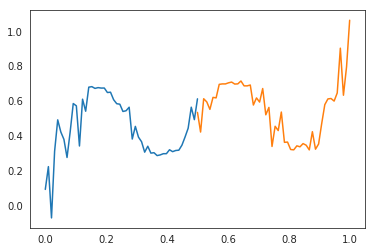

In [51]:
def make_data(N):
    def f(x):
        ϵ = 0.02*np.random.randn(x.shape[0])
        return x + 0.3*np.sin(2*π*(x + ϵ)) + 0.3*np.sin(4*π*(x + ϵ)) + ϵ
    
    x_train = np.linspace(0, 0.5, N)
    x_test = np.linspace(0.5, 1.0, N)
    y_train = f(x_train)
    y_test = f(x_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = make_data(50)
plt.plot(x_train, y_train, x_test, y_test);

$$h = \sigma(W_1x + b_1)$$
$$\hat{y} = W_2h + b_2 $$

In [0]:
def relu(z):
    return z*(z > 0)

def init_random_params(input_size, 
                       hidden_layer_size,
                       output_size,
                       scale=1,
                       seed=None):
    rs = np.random.RandomState(seed)
    
    W1 = scale*rs.randn(hidden_layer_size, input_size)
    b1 = scale*rs.randn(hidden_layer_size)
    
    W2 = scale*rs.randn(output_size, hidden_layer_size)
    b2 = scale*rs.randn(output_size)
    return W1, b1, W2, b2
    

def l2_regularization(params, λ):
    params_flat, _ = flatten(params)
    μ = params_flat
    σ = λ
    return norm.logpdf(μ, 0, σ).sum()


def neural_net_predict(params, x):
    """Implements a shallow neural network for regression.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns regression results."""
    W1, b1, W2, b2 = params
    h = relu(np.dot(W1, x) + b1)
    y_pred = relu(np.dot(W2, h) + b2)
    return y_pred


def log_likelihood(params, x: np.array, y: np.array, σ: float=0.1) -> float:
    μ = neural_net_predict(params, x)
    return norm.logpdf(μ, y, σ).sum()

def loss(params, x: np.array, y: np.array, σ: float=0.1, λ=1) -> float:
    return -log_likelihood(params, x, y, σ) - l2_regularization(params, λ)

## Tests

In [0]:
W1, b1, W2, b2 = (np.eye(3), np.zeros(3),
                  np.eye(3), np.zeros(3))
params = (W1, b1, W2, b2)

x = np.array([-1, 0, 1])
y = np.array([0, 0, 1])
σ = 1/np.sqrt(2*π)
λ = σ

# test neural_net_predict
assert np.isclose(neural_net_predict(params, x), y).all()

# test log_likelihood
y_ = y + 1
assert log_likelihood(params, x, y, σ) == 0
assert np.isclose(log_likelihood(params, x, y_, σ), -3*π)

# test l2_regularization
assert np.isclose(l2_regularization(params, λ), -6*π)

## Learning

### Gradient Descent (GD)

In [0]:
N = 1000
x_train, y_train, x_test, y_test = make_data(N)
input_size = x_train.shape[0]
hidden_layer_size = 1_000
output_size = y_train.shape[0]
lr = 0.01
λ = 10

# compute gradient
loss_grad = grad(loss)

# init params
params = init_random_params(input_size, hidden_layer_size, 
                            output_size, scale=0.01, seed=0)

# Gradient Descent
losses = list()
for i in range(2_000):
    loss_args = (params, x_train, y_train, 1, λ)
    Δparams  = loss_grad(*loss_args)   
    params = [p - Δp*lr for p, Δp in zip(params, Δparams)]
    
    losses.append(loss(*loss_args))

# Plot
plot_option = dict(
    style='x', 
    figsize=(12,5),
    ylim=(-0.5, 1.2),
    xlim=(-0.1, 1.2)
)


y_pred = np.concatenate((neural_net_predict(params, x_train),
                         neural_net_predict(params, x_test)))
x_pred = np.concatenate((x_train, x_test))

train = pd.Series(y_train, x_train).rename('train')
test = pd.Series(y_test, x_test).rename('test')
pred = pd.Series(y_pred, x_pred).rename('pred')

pd.concat((train, test, pred), axis=1).plot(**plot_option);

### SGD

In [0]:
# data
N = 1000
x_train, y_train, x_test, y_test = make_data(N)
input_size = x_train.shape[0]
hidden_layer_size = 50
output_size = y_train.shape[0]
λ = 2

# init params
params_init = init_random_params(input_size, hidden_layer_size, 
                                 output_size, scale=0.01, seed=0)



def objective(params, t):
    return loss(params, x, y, σ=0.1, λ=1)

optimized_params = adam(grad(objective), params_init,
                        step_size=0.01, num_iters=1000)